# Visualize GOES-16 Data from S3

#### This code retrieves a GOES-16 NetCDF file from the S3 bucket and visualize it. GOES makes 4 measurements in each hour, and only the first one is retrieved here. 

In [9]:
import xarray as xr
import requests
import netCDF4
import boto3
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 79
hour = 12
band = 3

In [11]:
def get_s3_keys(bucket, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    s3 = boto3.client('s3')
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [12]:
keys = get_s3_keys(bucket_name, prefix = product_name+'/'+ 
                                         str(year) + '/' + str(day_of_year).zfill(3) 
                                         + '/' + str(hour).zfill(2) + '/OR_'+ 
                                         product_name + '-M3C' + str(band).zfill(2))

key = [key for key in keys][0] # selecting the first measurement taken within the hour

In [13]:
resp = requests.get('https://' + bucket_name + '.s3.amazonaws.com/' + key)

In [14]:
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

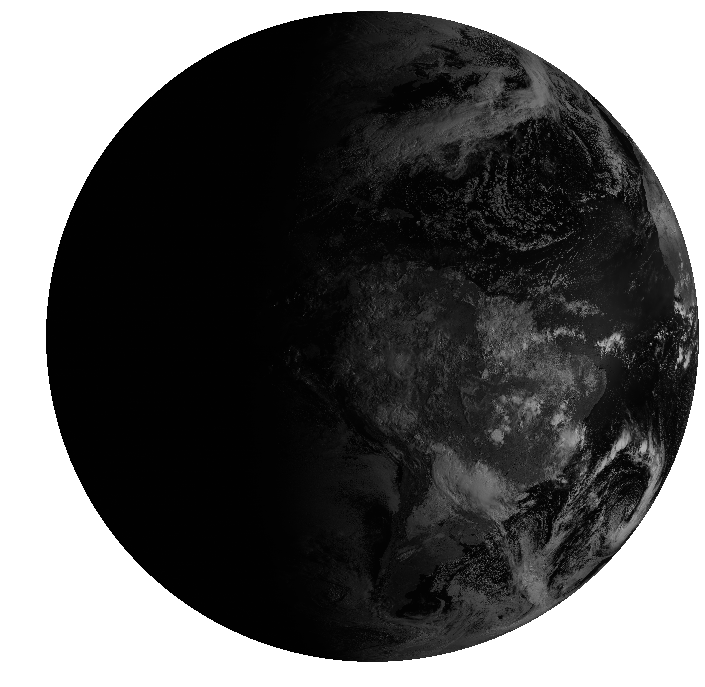

In [15]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.Rad, cmap='gray')
plt.axis('off')
plt.savefig(file_name + '.png', dpi=300, facecolor='w', edgecolor='w')